In [163]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from adjustText import adjust_text
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau
import numpy as np
import seaborn as sns

def plot_histograms(ax, metric, metric_type_df, resolutions, log_scale_metrics):
    for res in resolutions:
        col_name = f"{metric}{res}"
        this_type = metric_type_df[metric_type_df['metric']==metric]['type_2'].iloc[0]
        color_map = type_color_map[this_type]
        
        # Use log bins for specified metrics
        if metric in log_scale_metrics:
            values = values[values > 0]  # Avoid log of 0 or negative
            if len(values) > 0:
                bins = 50 # np.logspace(np.log10(values.min()), np.log10(values.max()), 10)
                ax.set_xscale("log")
                # Disable scientific notation on x-axis
                formatter = ScalarFormatter()
                formatter.set_scientific(False)
                formatter.set_useOffset(False)
                ax.xaxis.set_major_formatter(formatter)
            else:
                continue  # Skip empty or non-positive
        else:
            bins = 20
        
        if col_name in transformed_minmax_scaled.columns:
            sns.histplot(
                transformed_minmax_scaled[col_name].dropna(),
                bins=bins,
                kde=False,
                ax=ax,
                color=color_map[resolutions.index(res)],
                label=res,
                element='step',
                stat='density',
                fill=True,
                alpha=0.8,
            )
    ax.set_title(metric, fontsize=16)
    ax.tick_params(axis='both', labelsize=10)
    ax.grid(True)
    # ax.legend(title="Resolution", fontsize=10, title_fontsize=11)

def scatter_without_labels(ax, data, this_metric):
    for _, row in data.iterrows():
        metric_type = row["type_2"]
        resolution = row["resolution"]
        color = type_color_map[metric_type][resolution_index[resolution]]
        ax.scatter(row["rank_corr"], row["val_diff"], color=color, edgecolor='black',
                   marker='o', s=350, alpha=1)
    ax.set_title(this_metric, fontsize=20)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.set_xlabel("Spearman’s ρ", fontsize=15)
    ax.set_ylabel("MAD from 5m", fontsize=15)
    
    # Highlight box
    x_min, x_max = 0.9, 1.001
    y_min, y_max = 0, 0.2
    
    ax.tick_params(axis='both', which='major', labelsize=15)
#     rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
#                              linewidth=3, edgecolor='black', facecolor='none', linestyle='--')
#     ax.add_patch(rect)   
    
# Scatter function
def scatter_without_labels_cat(ax, data, this_metric):
    for _, row in data.iterrows():
        metric_type = row["type"]
        resolution = row["resolution"]
        color = type_color_map[metric_type][resolution_index[resolution]]
        ax.scatter(row["rank_corr"], row["val_diff"], color=color, edgecolor='black',
                   marker='o', s=350, alpha=1)
    ax.set_title(this_metric, fontsize=20)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.set_xlabel("Kendall’s τ", fontsize=15)
    ax.set_ylabel("% Different from 5m", fontsize=15)
    ax.set_ylim(0,70)
    x_min, x_max = 0.8, 1.001  
    y_min, y_max = 0, 10  
    ax.tick_params(axis='both', which='major', labelsize=15)
#     rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
#                              linewidth=3, edgecolor='black', facecolor='none', linestyle='--')
#     ax.add_patch(rect)


def split_metric_resolution(col_name):
    """
    Splits column names like '3rd_w_Peak_5m' into ('3rd_w_Peak', '5m').
    Assumes resolution is always the last underscore-suffix (e.g., '_5m').
    """
    parts = col_name.rsplit('_', 1)  # Split only on the last underscore
    if len(parts) == 2 and parts[1] in ['5m', '30m']:
        return parts[0], parts[1]
    else:
        return col_name, None  # No valid resolution suffix found
    
def compute_metric_sensitivity(df, continuous_metrics, categorical_metrics, resolutions=["DMC_10"]):
    rows = []

    for res in resolutions:
        for metric in continuous_metrics + categorical_metrics:
            ref_col = f"{metric}"
            comp_col = f"{metric}_{res}"
            if ref_col not in df.columns or comp_col not in df.columns:
                continue

            x_vals = df[ref_col]
            y_vals = df[comp_col]
            valid = x_vals.notna() & y_vals.notna()
            x = x_vals[valid]
            y = y_vals[valid]

            if len(x) < 2:
                continue

            is_continuous = metric in continuous_metrics
            if is_continuous:
                rank_corr, _ = spearmanr(x, y)
#                 val_diff = np.mean(np.abs(y - x))  # MAD
                # val_diff = np.median(np.abs((y - x) / np.where(x == 0, np.nan, x)) * 100)
                val_diff = 100 * np.mean(np.abs(y - x) / ((np.abs(x) + np.abs(y)) / 2))
            else:
                rank_corr, _ = kendalltau(x, y)
                observed_diff = np.mean(x != y) * 100  # raw % different
                observed_diff = observed_diff*100
                # Option A: Normalize based on number of classes in 5-min data
                n_classes = x.nunique()
                if n_classes > 1:
                    max_diff = (1 - 1 / n_classes) * 100  # convert to percent
                    val_diff = observed_diff / max_diff  # normalized disagreement
                else:
                    val_diff = 0  # No disagreement possible if only one class

            spread = gini(y)

            rows.append({
                "metric": metric,
                "resolution": res,
                "type": "continuous" if is_continuous else "categorical",
                "rank_corr": rank_corr,
                "val_diff": val_diff,
                "gini": spread
            })

    return pd.DataFrame(rows)

def gini(array):
    array = np.sort(np.array(array))
    n = len(array)
    if n == 0:
        return np.nan
    index = np.arange(1, n + 1)
    return (np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)) if np.sum(array) != 0 else 0




In [2]:
# First: Create the mapping for continuous metrics
metric_list = ['frac_q3_wi', 'peak_mean_ratio', 'cv', 'frac_q1_wi', 'time_kurtosis', 'Mean Intensity HIZ',
               '% rain HIZ', 'frac_q2_wi', 'event_dry_ratio', 'lorentz_asymetry', 'm5_wi', 'D50', 'm1',
               'Event Loading', 'time_to_peak', 'asymm_d', 'centre_gravity', 'max_intensity', 'm3_wi',
               'kurtosis', 'skewp', 'I30', 'peak_position_ratio', 'std', 'PCI', 'time_skewness', 'm1_wi',
               'mean_intensity', 'intermittency', 'T75', 'relative_amp', 'NRMSE_P', 'm2_wi', '% time LIZ',
               'm4_wi', 'T25', 'm2', 'skewness', '% time HIZ', 'centre_gravity_interpolated', 'frac_q4_wi',
               'gini', 'TCI']

type_2_list = ['Asymmetry', 'Peakiness', 'Peakiness', 'Asymmetry', 'Asymmetry', 'Peakiness', 'Concentration',
               'Asymmetry', 'Intermittency', 'Concentration', 'Asymmetry', 'Asymmetry', 'Asymmetry', 'Asymmetry',
               'Asymmetry', 'Asymmetry', 'Asymmetry', 'Peakiness', 'Asymmetry', 'Peakiness', 'Asymmetry', 'Peakiness',
               'Asymmetry', 'Peakiness', 'Concentration', 'Asymmetry', 'Asymmetry', 'Peakiness', 'Intermittency',
               'Asymmetry', 'Peakiness', 'Concentration', 'Peakiness', 'Concentration', 'Asymmetry', 'Asymmetry',
               'Peakiness', 'Peakiness', 'Concentration', 'Asymmetry', 'Concentration', 'Concentration', 'Concentration']

type_color_map = {
    'Asymmetry': sns.color_palette("Blues", 3),
    'Peakiness': sns.color_palette("Reds", 3),
    'Concentration': sns.color_palette("Greens", 3),
    'Intermittency': sns.color_palette("Purples", 3),
    'Categorical': sns.color_palette("Oranges", 3),
}

resolution_index = {'DMC_10': 2}

# Map type_2 to metrics
type_2_mapping = dict(zip(metric_list, type_2_list))

In [128]:
transformed_minmax_scaled = pd.read_csv("../NotScaled_RawVsDMC.csv")

column_names = transformed_minmax_scaled.columns.str.replace('_log', '')
column_names = column_names.str.replace('_yj', '')
# column_names = column_names.str.replace('_wi', '')
transformed_minmax_scaled.columns = column_names

In [130]:
categorical_metrics = ['3rd_ARR',  '3rd_rcg',  '3rd_w_peak', '4th_w_peak', '5th_w_peak', 'third_ppr', '3rd_w_most', 
                       '4th_w_most', '5th_w_most']
continuous_metrics = [metric for metric in column_names if metric not in categorical_metrics]

In [131]:
metric_base_names = {col.replace(suffix, '') for col in transformed_minmax_scaled.columns  for suffix in ['_DMC_10']  if col.endswith(suffix)}

In [132]:
# metrics = set()
# for col in transformed_minmax_scaled.columns:
#     metric, res = split_metric_resolution(col)
#     if res is not None:
#         metrics.add(metric)
# metrics = list(metrics)

# # metrics.remove('T50')
# metrics.remove('m5')
# metrics.remove('m4')
# metrics.remove('m3')
# metrics.remove('BSC_Index')

# categorical_metrics = ['3rd_ARR',  '3rd_rcg',  '3rd_w_peak', '4th_w_peak', '5th_w_peak', 'third_ppr', '3rd_w_most', 
#                        '4th_w_most', '5th_w_most']
# continuous_metrics = [metric for metric in metrics if metric not in categorical_metrics]

In [133]:
summary_df = compute_metric_sensitivity(df=transformed_minmax_scaled,
    continuous_metrics=continuous_metrics,
    categorical_metrics=categorical_metrics)
summary_df = summary_df[~summary_df['metric'].isin(['m3', 'm4', 'm5'])]

In [134]:
# # --- CONFIG ---
# resolutions = ['10m', '30m', '60m']
# resolution_colors = {'10m': '#1f77b4', '30m': '#ff7f0e', '60m': '#2ca02c'}

# # --- Extract all metrics present in transformed_minmax_scaled ---
# all_metric_names = filtered_df['metric'].unique()

# # --- Assign types ---
# metric_type_df = (
#     pd.DataFrame({'metric': all_metric_names})
#     .assign(type_2=lambda df: df['metric'].map(type_2_mapping)))
# metric_type_df.fillna('Categorical', inplace=True)

In [135]:
def spaced_colors_from_cmap(cmap_name, values=[0.1, 0.5, 0.9]):
    cmap = plt.get_cmap(cmap_name)
    # Drop the alpha channel → convert RGBA to RGB
    return [cmap(v)[:3] for v in values]  # returns list of RGB tuples in 0-1 range

In [136]:
intermittency_metrics = ['intermittency', 'event_dry_ratio']

In [137]:
# Filter the dataframe
filtered_df = summary_df[~summary_df["metric"].isin(['m3', 'm4', 'm5'])].copy()
filtered_df["type_2"] = filtered_df["metric"].map(type_2_mapping)

# Sort by type_2 and descending rank_corr
filtered_df = filtered_df.sort_values(
    by=["type_2", "rank_corr"],
    key=lambda col: (
        col.map({'Asymmetry': 0, 'Peakiness': 1, 'Concentration': 2, 'Intermittency': 3})
        if col.name == "type_2" else -col))

filtered_df.fillna('Categorical', inplace=True)

# Split intermittency and other types
df_intermittency = filtered_df[filtered_df["type_2"] == "Intermittency"]
df_other = filtered_df[(filtered_df["type_2"] != "Intermittency")&(filtered_df['type_2']!='Categorical')]
df_categorical = filtered_df[filtered_df["type_2"] == "Categorical"]
df_continuous =  pd.concat([df_other, df_intermittency])

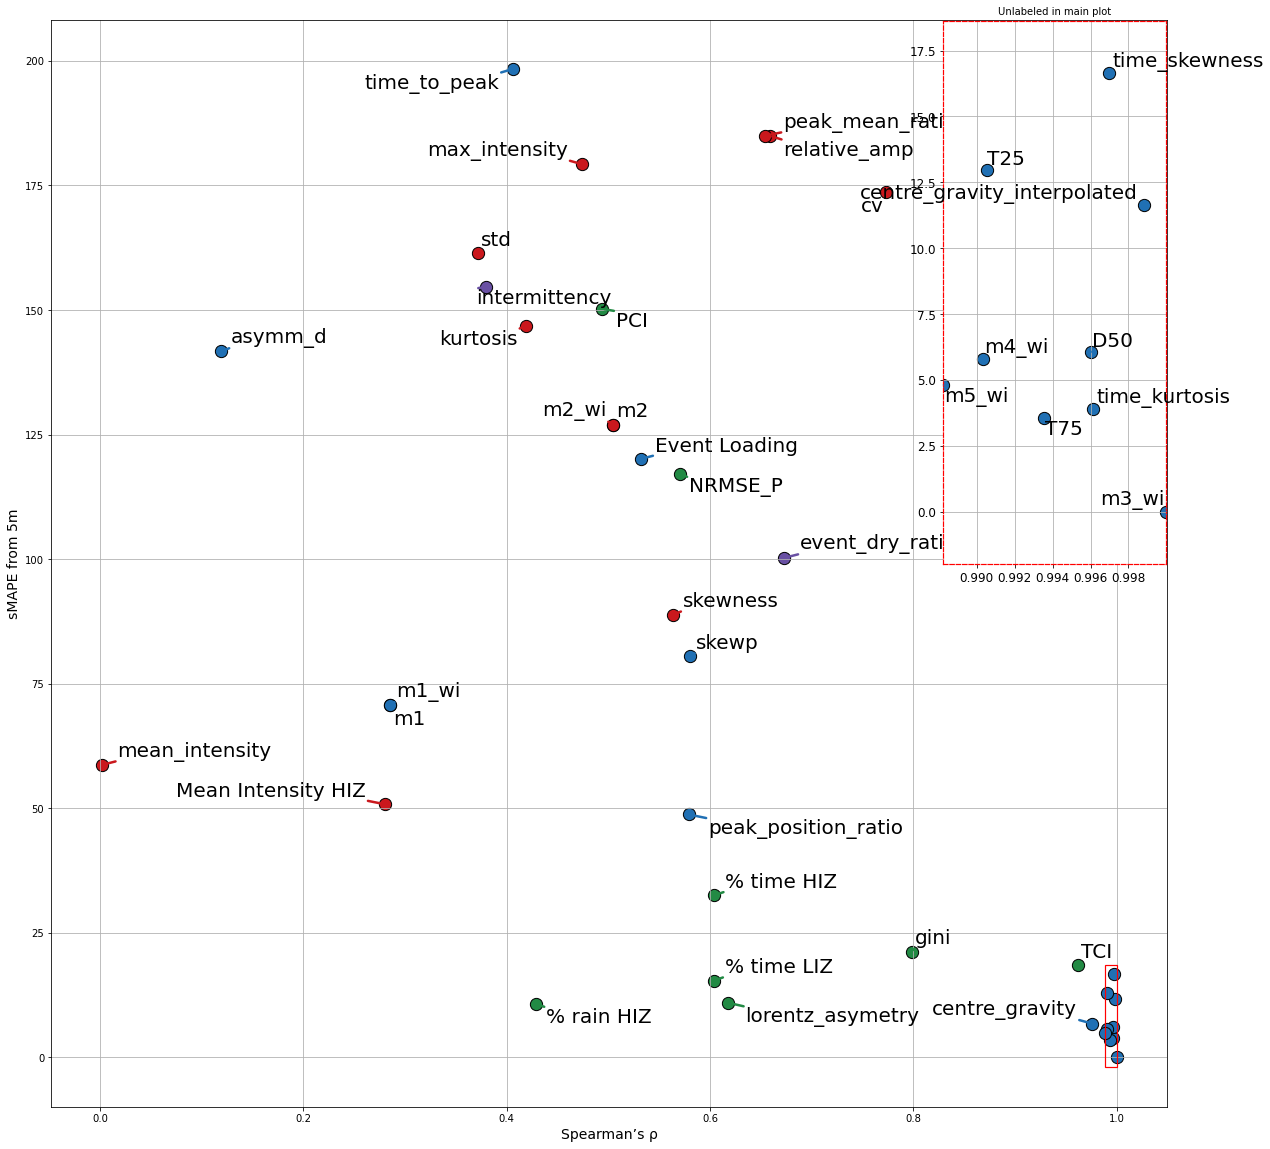

In [138]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
size=150
texts = []
face_colors = []
original_positions = []

# Determine which points to label
mask_label = ~((df_continuous["rank_corr"] > 0.98) & (df_continuous["val_diff"] < 25))
df_label = df_continuous[mask_label]
df_skip = df_continuous[~mask_label]

fig, ax = plt.subplots(figsize=(20, 20))

# --- Main plot: plot all points ---
for _, row in df_continuous.iterrows():
    face_color = type_color_map[row['type_2']][2]
    ax.scatter(
        row["rank_corr"], row["val_diff"],
        facecolor=face_color,
        edgecolor='black',
        marker=marker,
        s=size,
        alpha=1
    )

# --- Add labels to selected points ---
for _, row in df_label.iterrows():
    face_color = type_color_map[row['type_2']][2]
    original_positions.append((row["rank_corr"], row["val_diff"]))
    face_colors.append(face_color)
    
    txt = ax.text(row["rank_corr"], row["val_diff"], row["metric"],
                  fontsize=labelsize, color='black')
    texts.append(txt)

# --- Adjust labels ---
adjust_text(
    texts, ax=ax,
    arrowprops=None,
    expand_text=(1.05, 1.2),
    expand_points=(1.2, 1.4),
    only_move={'points': 'xy', 'text': 'xy'},
    force_points=0.2,
    force_text=0.2,
)

# --- Draw colored arrows ---
for txt, (x0, y0), face_color in zip(texts, original_positions, face_colors):
    x1, y1 = txt.get_position()
    ax.annotate("",
        xy=(x0, y0), xytext=(x1, y1),
        arrowprops=dict(arrowstyle='-', color=face_color, lw=2.5)
    )

# --- Inset plot for skipped labels ---
ax_inset = inset_axes(
    ax,
    width="20%", height="50%",
    loc='upper right',
    bbox_to_anchor=(0, 0, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0.1
)

# Make the inset axes border red to match the rectangle
for spine in ax_inset.spines.values():
    spine.set_edgecolor('red')
    spine.set_linewidth(1.2)
    spine.set_linestyle('--')

from adjustText import adjust_text

texts_inset = []
positions_inset = []
face_colors_inset = []

for _, row in df_skip.iterrows():
    face_color = type_color_map[row['type_2']][2]
    ax_inset.scatter(
        row["rank_corr"], row["val_diff"],
        facecolor=face_color,
        edgecolor='black',
        marker=marker,
        s=size * 1,
        alpha=1
    )
    positions_inset.append((row["rank_corr"], row["val_diff"]))
    face_colors_inset.append(face_color)
    
    txt = ax_inset.text(
        row["rank_corr"], row["val_diff"], row["metric"],
        fontsize=labelsize * 1, color='black'
    )
    texts_inset.append(txt)

# Adjust inset labels to avoid overlaps
adjust_text(
    texts_inset, ax=ax_inset,
    expand_text=(1.05, 1.2),
    expand_points=(1.2, 1.4),
    only_move={'points': 'xy', 'text': 'xy'},
    force_points=0.1,
    force_text=0.1,
    arrowprops=None  # or add arrows if needed
)

# Optionally: colored arrows in inset
for txt, (x0, y0), face_color in zip(texts_inset, positions_inset, face_colors_inset):
    x1, y1 = txt.get_position()
    ax_inset.annotate("",
        xy=(x0, y0), xytext=(x1, y1),
        arrowprops=dict(arrowstyle='-', color=face_color, lw=1)
    )
    
# Tidy inset plot
ax_inset.set_title("Unlabeled in main plot", fontsize=10)
ax_inset.tick_params(labelsize=5)
ax_inset.grid(True)

# Match inset limits for spatial consistency
ax_inset.set_xlim(df_skip["rank_corr"].min(), df_skip["rank_corr"].max())
ax_inset.set_ylim(df_skip["val_diff"].min() - 2, df_skip["val_diff"].max() + 2)

# --- Main axes setup ---
ax.set_xlabel("Spearman’s ρ", fontsize=14)
ax.set_ylabel("sMAPE from 5m", fontsize=14)
ax.grid(True)

ax_inset.tick_params(axis='both', which='major', labelsize=12)

import matplotlib.patches as patches

# Coordinates & size of inset zoom region (same as inset x/y limits)
x0, x1 = ax_inset.get_xlim()
y0, y1 = ax_inset.get_ylim()

# Create a rectangle patch
rect = patches.Rectangle(
    (x0, y0),         # bottom-left corner
    x1 - x0,          # width
    y1 - y0,          # height
    linewidth=1.2,
    edgecolor='red',  # color of the box outline
    facecolor='none', # transparent fill
    linestyle='-',
    zorder=5          # draw on top
)

# Add the rectangle to the main axes
ax.add_patch(rect)

from matplotlib.lines import Line2D

# Define corners of rectangle
corners = [(x0, y0), (x0, y1), (x1, y1), (x1, y0)]
# Define corresponding corners in inset axes (in data coords)
inset_corners = [
    (ax_inset.get_xlim()[0], ax_inset.get_ylim()[0]),
    (ax_inset.get_xlim()[0], ax_inset.get_ylim()[1]),
    (ax_inset.get_xlim()[1], ax_inset.get_ylim()[1]),
    (ax_inset.get_xlim()[1], ax_inset.get_ylim()[0])
]

for (x_main, y_main), (x_in, y_in) in zip(corners, inset_corners):
    line = Line2D([x_main, x_in], [y_main, y_in],
                  transform=ax.transData,
                  color='red', linestyle='--', linewidth=2)
    fig.add_artist(line)

# plt.tight_layout()
plt.show()
fig.savefig("Figures/Scatter_continuous_DMC10.png", dpi=300, facecolor='white')

In [139]:
# texts = []
# face_colors = []
# original_positions = []

# fig, ax = plt.subplots(figsize=(15, 10))

# for _, row in df_continuous.iterrows():
#     face_color = type_color_map[row['type_2']][2]
    
#     # Scatter point
#     ax.scatter(
#         row["rank_corr"],
#         row["val_diff"],
#         facecolor=face_color,
#         edgecolor='black',
#         marker=marker,
#         s=size,
#         alpha=1
#     )
    
#     # Clean label name
#     metric_name = row["metric"]
    
#     # Store original point and face color
#     original_positions.append((row["rank_corr"], row["val_diff"]))
#     face_colors.append(face_color)
    
#     # Add black text label
#     txt = ax.text(row["rank_corr"], row["val_diff"], metric_name,
#                   fontsize=labelsize, color='black')
#     texts.append(txt)

# # Adjust text positions (no arrows drawn here)
# adjust_text(
#     texts,
#     ax=ax,
#     arrowprops=None,
#     expand_text=(1.05, 1.2),
#     expand_points=(1.2, 1.4),
#     only_move={'points': 'y', 'text': 'xy'},
#     force_points=0.1,
#     force_text=0.1
# )

# # Draw arrows with matching scatter face color
# for txt, (x0, y0), face_color in zip(texts, original_positions, face_colors):
#     x1, y1 = txt.get_position()
#     ax.annotate("",
#         xy=(x0, y0),
#         xytext=(x1, y1),
#         arrowprops=dict(arrowstyle='-', color=face_color, lw=0.5)
#     )

# # Axes labels and grid
# ax.set_xlabel("Spearman’s ρ", fontsize=14)
# ax.set_ylabel("MAD from 5m", fontsize=14)
# ax.grid(True)


In [140]:
df_continuous_high = df_continuous[df_continuous['rank_corr']>0.8]

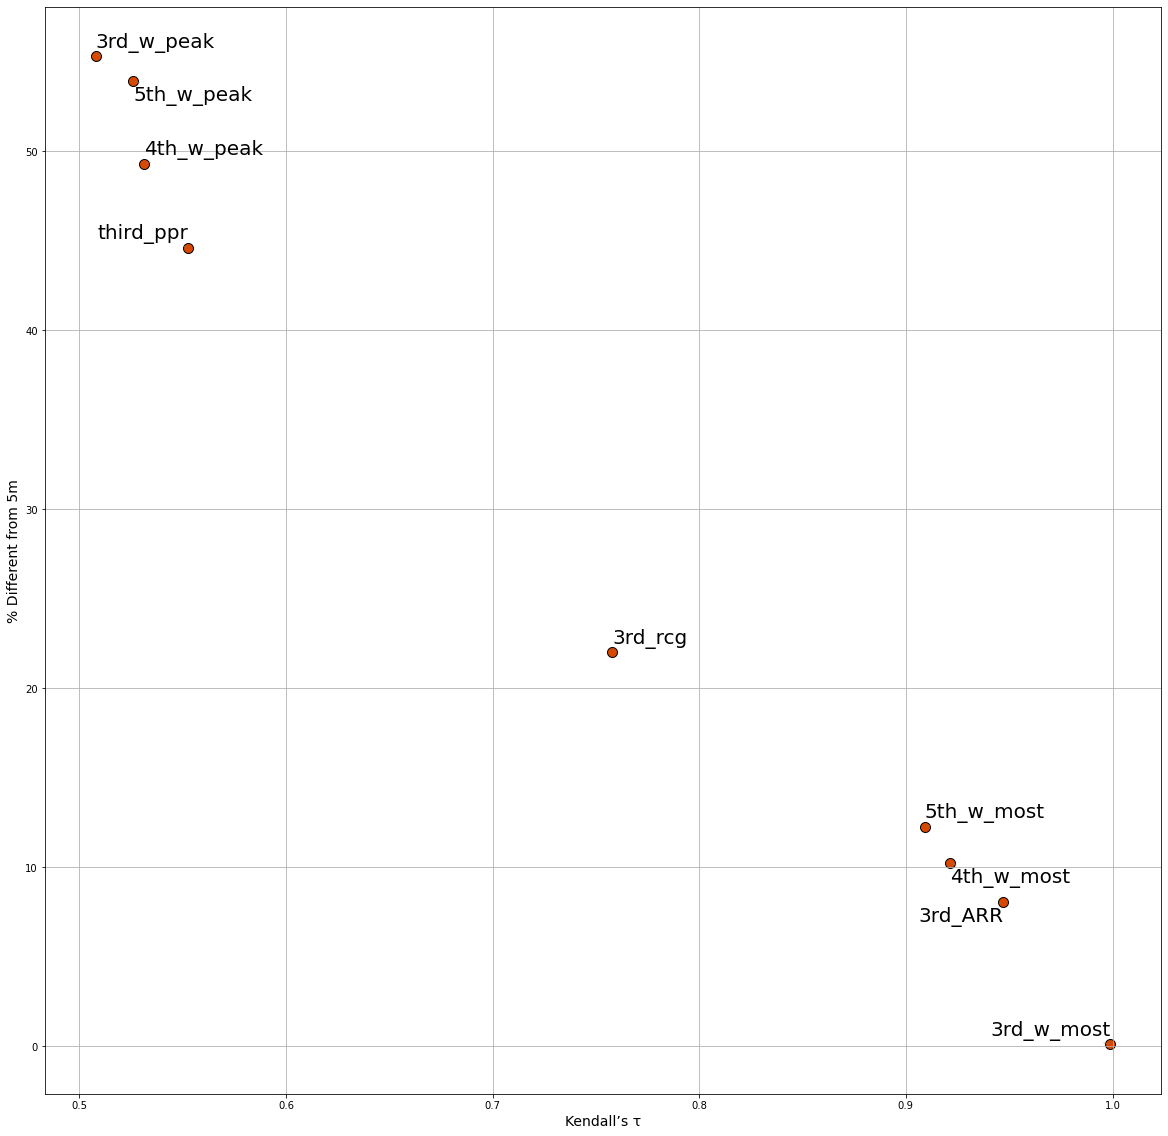

In [141]:
fig, ax = plt.subplots(figsize=(20, 20))

marker = 'o'
size = 100
labelsize = 20
texts = []

for _, row in df_categorical.iterrows():
    # Scatter point
    ax.scatter(
        row["rank_corr"],
        row["val_diff"],
        facecolor=type_color_map[row['type_2']][2],
        edgecolor='black',
        marker=marker,
        s=size,
        alpha=1
    )
    # Clean label name
    metric_name = row["metric"].replace('_wi', '')
    
    # Create text object (to be adjusted later)
    texts.append(
        ax.text(row["rank_corr"], row["val_diff"], metric_name, fontsize=labelsize)
    )

# Axes labels
ax.set_xlabel("Kendall’s τ", fontsize=14)
ax.set_ylabel("% Different from 5m", fontsize=14)
ax.grid(True)
# Adjust text to avoid overlaps
adjust_text(
    texts,
    ax=ax,
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
    expand_text=(1.05, 1.2),
    expand_points=(1.2, 1.4),
    only_move={'points': 'y', 'text': 'xy'},
    force_points=0.3,
    force_text=0.3
)

# plt.tight_layout()
# plt.show()
fig.savefig("Figures/Scatter_categorical_DMC10.png", dpi=300, facecolor='white')